In [208]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import *
import xgboost as xgb

from sklearn.preprocessing import PowerTransformer


import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [209]:
df = pd.read_csv("cleaned_df.csv")

df["Policy Start Date"] = pd.to_datetime(df["Policy Start Date"])

In [210]:
df.shape

(2000000, 20)

In [211]:
df.isnull().sum()

Age                          0
Gender                       0
Annual Income                0
Marital Status               0
Number of Dependents         0
Education Level              0
Occupation                   0
Health Score                 0
Location                     0
Policy Type                  0
Previous Claims              0
Vehicle Age                  0
Credit Score                 0
Insurance Duration           0
Policy Start Date            0
Customer Feedback            0
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount          800000
dtype: int64

In [212]:
train = df.iloc[:1200000, :]
train.shape

(1200000, 20)

In [213]:
test = df.iloc[1200000:, :]
test.shape

(800000, 20)

In [214]:
test.head(3)

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
1200000,28.0,Female,2310.0,Single,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,2.0,19.0,493.0,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House,NaN
1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,1.0,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment,NaN
1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,1.0,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo,NaN


#
---
#

# Adding Dates columns

In [215]:
df["Policy Start Date - Day"] = df["Policy Start Date"].dt.day
df["Policy Start Date - Month"] = df["Policy Start Date"].dt.month
df["Policy Start Date - Year"] = df["Policy Start Date"].dt.year

In [216]:
df["Policy Start Date - Quarter"] = df["Policy Start Date"].dt.year.astype(str) + " Q" + df["Policy Start Date"].dt.quarter.astype(str)

In [217]:
df.head(3)

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy Start Date - Day,Policy Start Date - Month,Policy Start Date - Year,Policy Start Date - Quarter
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0,23,12,2023,2023 Q4
1,39.0,Female,31678.0,Divorced,3.0,Master's,Self-Employed,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0,12,6,2023,2023 Q2
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,555.0,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0,30,9,2023,2023 Q3


#
---
#

In [218]:
data = df.copy()

#
---
#

In [219]:
df.drop(columns="Policy Start Date", inplace=True)

In [220]:
df.head(3)

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount,Policy Start Date - Day,Policy Start Date - Month,Policy Start Date - Year,Policy Start Date - Quarter
0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,Premium,2.0,17.0,372.0,5.0,Poor,No,Weekly,House,2869.0,23,12,2023,2023 Q4
1,39.0,Female,31678.0,Divorced,3.0,Master's,Self-Employed,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,Average,Yes,Monthly,House,1483.0,12,6,2023,2023 Q2
2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,555.0,3.0,Good,Yes,Weekly,House,567.0,30,9,2023,2023 Q3


In [221]:
df[["Policy Start Date - Day", "Policy Start Date - Month", "Policy Start Date - Year"]] = df[["Policy Start Date - Day", "Policy Start Date - Month", "Policy Start Date - Year"]].astype("O")

In [222]:
def show_nulls(df):
    nulls = []
    nuniques = []
    uniques = []
    types = []
    
    for i in df.columns:
        nulls.append(df[i].isnull().sum())
        nuniques.append(df[i].nunique())
        uniques.append(df[i].unique())
        types.append(df[i].dtype)
    
    
    return pd.DataFrame(
        {
            "Column" : df.columns,
            "Data Type" : types,
            "Nulls" : nulls,
            "No. of Uniques" : nuniques,
            "Uniques" : uniques
        }
    ).sort_values(by="Nulls", ascending=False)

In [223]:
show_nulls(df)

,Column,Data Type,Nulls,No. of Uniques,Uniques
18,Premium Amount,float64,800000,4794,"[2869.0, 1483.0, 567.0, 765.0, 2022.0, 3202.0,..."
1,Gender,object,0,2,"[Female, Male]"
0,Age,float64,0,47,"[19.0, 39.0, 23.0, 21.0, 29.0, 41.0, 48.0, 44...."
3,Marital Status,object,0,3,"[Married, Divorced, Single]"
4,Number of Dependents,float64,0,5,"[1.0, 3.0, 2.0, 0.0, 4.0]"
5,Education Level,object,0,4,"[Bachelor's, Master's, High School, PhD]"
2,Annual Income,float64,0,97952,"[10049.0, 31678.0, 25602.0, 141855.0, 39651.0,..."
6,Occupation,object,0,3,"[Self-Employed, Employed, Unemployed]"
7,Health Score,float64,0,934000,"[22.59876067181393, 15.569730989408043, 47.177..."
9,Policy Type,object,0,3,"[Premium, Comprehensive, Basic]"


#
---
#

In [224]:
def return_splits(ddf, feature_name, target_name):
    return [ddf[ddf[feature_name] == i][target_name] for i in ddf[feature_name].unique()]

def give_stats_analysis(df, target_column_name):
    ddf = df.copy()
    ddf = ddf.dropna()

    features = []
    tests = []
    stats = []
    pvals = []
    verdict = []
    count = 0

    target = ddf[target_column_name]
    for i in ddf.columns:
        features.append(i)
        feature = ddf[i]
        
        if (feature.dtype == "O" and (target.dtype == "float" or target.dtype == "int")) or (target.dtype == "O" and (feature.dtype == "float" or feature.dtype == "int")):
            stat, pval, *_ = kruskal(*return_splits(ddf, feature.name, target.name))
            tests.append("Kruskal-Wallis")
            stats.append(stat)
            pvals.append(pval)
            
        
        elif (feature.dtype == "float" or feature.dtype == "int") and (target.dtype == "float" or target.dtype == "int"):
            stat, pval, *_ = spearmanr(feature, target)
            tests.append("SpearmanR")
            stats.append(stat)
            pvals.append(pval)

        elif feature.dtype == "O" and target.dtype == "O":
            stat, pval, *_ = chi2_contingency(pd.crosstab(feature, target))
            tests.append("Chi-Square")
            stats.append(stat)
            pvals.append(pval)
        
        else:
            tests.append(np.nan)
            stats.append(np.nan)
            pvals.append(np.nan)
        
        if pval <= 0.025:
            verdict.append("There is Relationship")
        else:
            verdict.append("There is NO Relationship")

        print(f"{feature.name} ■■■ {target_column_name}".ljust(50, "-")+"✅")
    
    return pd.DataFrame({
        "Feature" : features,
        "Target" : [target_column_name]*ddf.shape[1],
        "Statistic Test" : tests,
        "Test Statistic" : stats,
        "P-Value" : pvals,
        "Verdict" : verdict
    }).sort_values(by="P-Value")

# H0 :- There is ***No Relationship*** among the given two columns
# H1 :- There is ***Relationship*** among the given two columns

### ***Health-related indicators***
- [x] Health Score
- [x] Smoking Status
- [x] Exercise Frequency
### ***Demographic information***
- [x] Age
- [x] Gender
- [x] Marital Status
- [x] Number of Dependents
- [x] Occupation
### ***Policy details***
- [x] Policy Type
- [x] Policy Start Date
- [x] Insurance Duration
### ***Financial factors***
- [x] Annual Income
- [x] Credit Score.
### ***Premium calculation***
- [x] Premium Amount

In [225]:
stats_result = give_stats_analysis(df.iloc[:1200000, :], "Premium Amount")
stats_result

Age ■■■ Premium Amount----------------------------✅
Gender ■■■ Premium Amount-------------------------✅
Annual Income ■■■ Premium Amount------------------✅
Marital Status ■■■ Premium Amount-----------------✅
Number of Dependents ■■■ Premium Amount-----------✅
Education Level ■■■ Premium Amount----------------✅
Occupation ■■■ Premium Amount---------------------✅
Health Score ■■■ Premium Amount-------------------✅
Location ■■■ Premium Amount-----------------------✅
Policy Type ■■■ Premium Amount--------------------✅
Previous Claims ■■■ Premium Amount----------------✅
Vehicle Age ■■■ Premium Amount--------------------✅
Credit Score ■■■ Premium Amount-------------------✅
Insurance Duration ■■■ Premium Amount-------------✅
Customer Feedback ■■■ Premium Amount--------------✅
Smoking Status ■■■ Premium Amount-----------------✅
Exercise Frequency ■■■ Premium Amount-------------✅
Property Type ■■■ Premium Amount------------------✅
Premium Amount ■■■ Premium Amount-----------------✅
Policy Start

,Feature,Target,Statistic Test,Test Statistic,P-Value,Verdict
2,Annual Income,Premium Amount,SpearmanR,-0.060743,0.000000e+00,There is Relationship
12,Credit Score,Premium Amount,SpearmanR,-0.037140,0.000000e+00,There is Relationship
18,Premium Amount,Premium Amount,SpearmanR,1.000000,0.000000e+00,There is Relationship
10,Previous Claims,Premium Amount,SpearmanR,0.031065,6.140967e-254,There is Relationship
21,Policy Start Date - Year,Premium Amount,Kruskal-Wallis,744.007760,1.495212e-158,There is Relationship
22,Policy Start Date - Quarter,Premium Amount,Kruskal-Wallis,762.405096,1.339135e-148,There is Relationship
7,Health Score,Premium Amount,SpearmanR,0.016407,3.113085e-72,There is Relationship
20,Policy Start Date - Month,Premium Amount,Kruskal-Wallis,70.518156,9.736743e-11,There is Relationship
14,Customer Feedback,Premium Amount,Kruskal-Wallis,31.155459,1.716635e-07,There is Relationship
6,Occupation,Premium Amount,Kruskal-Wallis,14.927461,5.735127e-04,There is Relationship


# <ins>Key Premium as per Reseach Papers and as per dataset.</ins>
### `Strikeoff features are said by research and dataset too. But unstrike ones are not impactful to determine premium amount as per dataset but as per research it should be. We need to find why like so in these features`

- ### ~~Age~~
- ### Gender
- ### ~~Health Score~~
- ### Smoking Status
- ### Exercise Frequency
- ### ~~Occupation~~
- ### Policy Type
- ### ~~Previous Claims~~
- ### ~~Annual Income~~
- ### Insurance Duration
- ### ~~Credit Score~~

#
---
#

In [226]:
cols = ["Gender", "Smoking Status", "Exercise Frequency", "Policy Type", "Insurance Duration"]

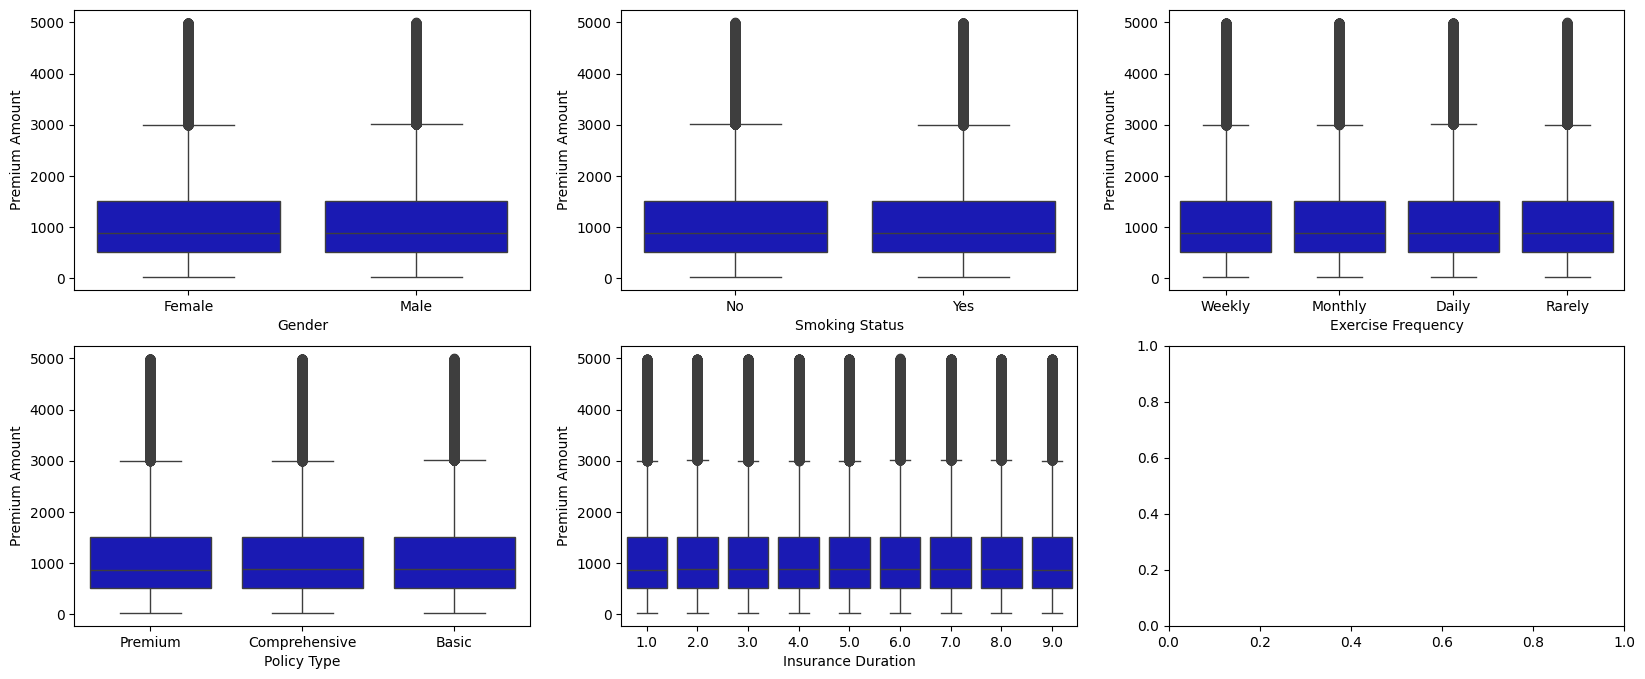

In [227]:
fig, axs = plt.subplots(2, 3, figsize=(20, 8))
for col, ax in zip(cols, axs.flatten()):
    sns.boxplot(y=df["Premium Amount"], x=df[col], color="mediumblue", ax=ax)

In [228]:
useless_columns = stats_result[stats_result["P-Value"] >= 0.025]["Feature"]
useless_columns

8                    Location
5             Education Level
11                Vehicle Age
9                 Policy Type
17              Property Type
16         Exercise Frequency
15             Smoking Status
19    Policy Start Date - Day
1                      Gender
13         Insurance Duration
Name: Feature, dtype: object

In [229]:
meaningless_df = df[useless_columns]
meaningless_df.head(3)

,Location,Education Level,Vehicle Age,Policy Type,Property Type,Exercise Frequency,Smoking Status,Policy Start Date - Day,Gender,Insurance Duration
0,Urban,Bachelor's,17.0,Premium,House,Weekly,No,23,Female,5.0
1,Rural,Master's,12.0,Comprehensive,House,Monthly,Yes,12,Female,2.0
2,Suburban,High School,14.0,Premium,House,Weekly,Yes,30,Male,3.0


In [230]:
df = df[stats_result[stats_result["P-Value"] < 0.025]["Feature"]]
df.head(3)

,Annual Income,Credit Score,Premium Amount,Previous Claims,Policy Start Date - Year,Policy Start Date - Quarter,Health Score,Policy Start Date - Month,Customer Feedback,Occupation,Age,Number of Dependents,Marital Status
0,10049.0,372.0,2869.0,2.0,2023,2023 Q4,22.598761,12,Poor,Self-Employed,19.0,1.0,Married
1,31678.0,694.0,1483.0,1.0,2023,2023 Q2,15.569731,6,Average,Self-Employed,39.0,3.0,Divorced
2,25602.0,555.0,567.0,1.0,2023,2023 Q3,47.177549,9,Good,Self-Employed,23.0,3.0,Divorced


# Compressing Meaningless DF's information in a component using PCA

In [231]:
meaningless_df.head(3)

,Location,Education Level,Vehicle Age,Policy Type,Property Type,Exercise Frequency,Smoking Status,Policy Start Date - Day,Gender,Insurance Duration
0,Urban,Bachelor's,17.0,Premium,House,Weekly,No,23,Female,5.0
1,Rural,Master's,12.0,Comprehensive,House,Monthly,Yes,12,Female,2.0
2,Suburban,High School,14.0,Premium,House,Weekly,Yes,30,Male,3.0


## Endoing Columns

In [232]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

###
---
###

In [233]:
meaningless_df["Location"].unique()

array(['Urban', 'Rural', 'Suburban'], dtype=object)

In [234]:
a = OrdinalEncoder(categories=[['Rural', 'Suburban', 'Urban']])

b = pd.DataFrame({"ENCODED_Location" : a.fit_transform(meaningless_df[["Location"]]).flatten()})

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Location", inplace=True)

###
---
###

In [235]:
meaningless_df["Education Level"].unique()

array(["Bachelor's", "Master's", 'High School', 'PhD'], dtype=object)

In [236]:
a = OrdinalEncoder(categories=[['High School', "Bachelor's", "Master's", 'PhD']])

b = pd.DataFrame({"ENCODED_Education Level" : a.fit_transform(meaningless_df[["Education Level"]]).flatten()})

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Education Level", inplace=True)

###
---
###

In [237]:
meaningless_df["Policy Type"].unique()

array(['Premium', 'Comprehensive', 'Basic'], dtype=object)

In [238]:
a = OrdinalEncoder(categories=[['Basic', 'Comprehensive', 'Premium']])

b = pd.DataFrame({"ENCODED_Policy Type" : a.fit_transform(meaningless_df[["Policy Type"]]).flatten()})

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Policy Type", inplace=True)

###
---
###

In [239]:
a = OneHotEncoder(drop="first", sparse_output=False)

b = pd.DataFrame(
        a.fit_transform(meaningless_df[["Property Type"]]),
        columns=a.get_feature_names_out()
    )

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Property Type", inplace=True)

###
---
###

In [240]:
meaningless_df["Exercise Frequency"].unique()

array(['Weekly', 'Monthly', 'Daily', 'Rarely'], dtype=object)

In [241]:
a = OrdinalEncoder(categories=[['Rarely', 'Monthly', 'Weekly', 'Daily']])

b = pd.DataFrame({"ENCODED_Exercise Frequency" : a.fit_transform(meaningless_df[["Exercise Frequency"]]).flatten()})

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Exercise Frequency", inplace=True)

###
---
###

In [242]:
a = OneHotEncoder(drop="first", sparse_output=False)

b = pd.DataFrame(
        a.fit_transform(meaningless_df[["Smoking Status"]]),
        columns=a.get_feature_names_out()
    )

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Smoking Status", inplace=True)

###
---
###

In [243]:
a = OneHotEncoder(drop="first", sparse_output=False)

b = pd.DataFrame(
        a.fit_transform(meaningless_df[["Gender"]]),
        columns=a.get_feature_names_out()
    )

meaningless_df = pd.concat([meaningless_df, b], axis=1)
meaningless_df.drop(columns="Gender", inplace=True)

###
---
###

In [244]:
meaningless_df["Policy Start Date - Day"] = meaningless_df["Policy Start Date - Day"].astype(int)

#
---
#

In [245]:
meaningless_df.head(3)

,Vehicle Age,Policy Start Date - Day,Insurance Duration,ENCODED_Location,ENCODED_Education Level,ENCODED_Policy Type,Property Type_Condo,Property Type_House,ENCODED_Exercise Frequency,Smoking Status_Yes,Gender_Male
0,17.0,23,5.0,2.0,1.0,2.0,0.0,1.0,2.0,0.0,0.0
1,12.0,12,2.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,0.0
2,14.0,30,3.0,1.0,0.0,2.0,0.0,1.0,2.0,1.0,1.0


In [246]:
meaningless_df.dtypes

Vehicle Age                   float64
Policy Start Date - Day         int64
Insurance Duration            float64
ENCODED_Location              float64
ENCODED_Education Level       float64
ENCODED_Policy Type           float64
Property Type_Condo           float64
Property Type_House           float64
ENCODED_Exercise Frequency    float64
Smoking Status_Yes            float64
Gender_Male                   float64
dtype: object

###
---
###

# Doing PCA on this `meaningless_df`

In [247]:
from sklearn.decomposition import PCA

In [248]:
pca = PCA(n_components=3)
pca_df = pd.DataFrame(pca.fit_transform(meaningless_df), columns=['PC1_Meaningless_df', "PC2_Meaningless_df", "PC3_Meaningless_df"])
pca_df

,PC1_Meaningless_df,PC2_Meaningless_df,PC3_Meaningless_df
0,7.296560,7.422362,-0.026015
1,-3.707459,2.428130,-3.023998
2,14.294341,4.412807,-2.019879
3,-3.718270,-9.573107,-4.005108
4,-14.711684,-1.558834,-1.020776
...,...,...,...
1999995,-6.711192,-1.568796,-3.017960
1999996,12.281364,-9.586366,-3.000567
1999997,14.289683,0.417671,0.985283
1999998,-6.704185,7.438721,1.969261


In [249]:
pca.explained_variance_ratio_

array([0.63380533, 0.2723782 , 0.05496682])

###
---
###

# Combining 2 PCs of Meaningless_columns to the df

In [250]:
df = pd.concat([df, pca_df.iloc[:, :2]], axis=1)

In [251]:
df.head()

,Annual Income,Credit Score,Premium Amount,Previous Claims,Policy Start Date - Year,Policy Start Date - Quarter,Health Score,Policy Start Date - Month,Customer Feedback,Occupation,Age,Number of Dependents,Marital Status,PC1_Meaningless_df,PC2_Meaningless_df
0,10049.0,372.0,2869.0,2.0,2023,2023 Q4,22.598761,12,Poor,Self-Employed,19.0,1.0,Married,7.296560,7.422362
1,31678.0,694.0,1483.0,1.0,2023,2023 Q2,15.569731,6,Average,Self-Employed,39.0,3.0,Divorced,-3.707459,2.428130
2,25602.0,555.0,567.0,1.0,2023,2023 Q3,47.177549,9,Good,Self-Employed,23.0,3.0,Divorced,14.294341,4.412807
3,141855.0,367.0,765.0,1.0,2024,2024 Q2,10.938144,6,Poor,Self-Employed,21.0,2.0,Married,-3.718270,-9.573107
4,39651.0,598.0,2022.0,0.0,2021,2021 Q4,20.376094,12,Poor,Self-Employed,21.0,1.0,Single,-14.711684,-1.558834


###
---
###

# Encoding of column in `df`

In [252]:
show_nulls(df)

,Column,Data Type,Nulls,No. of Uniques,Uniques
2,Premium Amount,float64,800000,4794,"[2869.0, 1483.0, 567.0, 765.0, 2022.0, 3202.0,..."
0,Annual Income,float64,0,97952,"[10049.0, 31678.0, 25602.0, 141855.0, 39651.0,..."
1,Credit Score,float64,0,550,"[372.0, 694.0, 555.0, 367.0, 598.0, 614.0, 807..."
3,Previous Claims,float64,0,10,"[2.0, 1.0, 0.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ..."
4,Policy Start Date - Year,object,0,6,"[2023, 2024, 2021, 2022, 2020, 2019]"
5,Policy Start Date - Quarter,object,0,21,"[2023 Q4, 2023 Q2, 2023 Q3, 2024 Q2, 2021 Q4, ..."
6,Health Score,float64,0,934000,"[22.59876067181393, 15.569730989408043, 47.177..."
7,Policy Start Date - Month,object,0,12,"[12, 6, 9, 5, 2, 8, 3, 10, 1, 4, 7, 11]"
8,Customer Feedback,object,0,3,"[Poor, Average, Good]"
9,Occupation,object,0,3,"[Self-Employed, Employed, Unemployed]"


### Policy Start Date - Year	

In [253]:
df["Policy Start Date - Year"].unique()

array([2023, 2024, 2021, 2022, 2020, 2019], dtype=object)

In [254]:
a = OrdinalEncoder(categories=[[2019, 2020, 2021, 2022, 2023, 2024]])

b = pd.DataFrame({"ENCODED_Policy Start Date - Year" : a.fit_transform(df[["Policy Start Date - Year"]]).flatten()})

df = pd.concat([df, b], axis=1)
df.drop(columns="Policy Start Date - Year", inplace=True)

### Policy Start Date - Quarter

In [255]:
sorted(list(df["Policy Start Date - Quarter"].unique()))

['2019 Q3',
 '2019 Q4',
 '2020 Q1',
 '2020 Q2',
 '2020 Q3',
 '2020 Q4',
 '2021 Q1',
 '2021 Q2',
 '2021 Q3',
 '2021 Q4',
 '2022 Q1',
 '2022 Q2',
 '2022 Q3',
 '2022 Q4',
 '2023 Q1',
 '2023 Q2',
 '2023 Q3',
 '2023 Q4',
 '2024 Q1',
 '2024 Q2',
 '2024 Q3']

In [256]:
a = OrdinalEncoder(categories=[['2019 Q3', '2019 Q4', '2020 Q1', '2020 Q2', '2020 Q3', '2020 Q4', '2021 Q1', '2021 Q2', '2021 Q3',
                 '2021 Q4', '2022 Q1', '2022 Q2', '2022 Q3', '2022 Q4', '2023 Q1', '2023 Q2', '2023 Q3', '2023 Q4', '2024 Q1', '2024 Q2', '2024 Q3']])

b = pd.DataFrame({"ENCODED_Policy Start Date - Quarter" : a.fit_transform(df[["Policy Start Date - Quarter"]]).flatten()})

df = pd.concat([df, b], axis=1)
df.drop(columns="Policy Start Date - Quarter", inplace=True)

### Policy Start Date - Month

In [257]:
df["Policy Start Date - Month"] = df["Policy Start Date - Month"].astype(int)

### Customer Feedback

In [258]:
df["Customer Feedback"].unique()

array(['Poor', 'Average', 'Good'], dtype=object)

In [259]:
a = OrdinalEncoder(categories=[['Poor', 'Average', 'Good']])

b = pd.DataFrame({"ENCODED_Customer Feedback" : a.fit_transform(df[["Customer Feedback"]]).flatten()})

df = pd.concat([df, b], axis=1)
df.drop(columns="Customer Feedback", inplace=True)

### Occupation

In [260]:
a = OneHotEncoder(drop="first", sparse_output=False)

b = pd.DataFrame(
        a.fit_transform(df[["Occupation"]]),
        columns="ENCODED_" + a.get_feature_names_out()
    )

df = pd.concat([df, b], axis=1)
df.drop(columns="Occupation", inplace=True)

### Marital Status

In [263]:
a = OneHotEncoder(drop="first", sparse_output=False)

b = pd.DataFrame(
        a.fit_transform(df[["Marital Status"]]),
        columns="ENCODED_" + a.get_feature_names_out()
    )

df = pd.concat([df, b], axis=1)
df.drop(columns="Marital Status", inplace=True)

In [265]:
df.dtypes

Annual Income                          float64
Credit Score                           float64
Premium Amount                         float64
Previous Claims                        float64
Health Score                           float64
Policy Start Date - Month                int64
Age                                    float64
Number of Dependents                   float64
PC1_Meaningless_df                     float64
PC2_Meaningless_df                     float64
ENCODED_Policy Start Date - Year       float64
ENCODED_Policy Start Date - Quarter    float64
ENCODED_Customer Feedback              float64
ENCODED_Occupation_Self-Employed       float64
ENCODED_Occupation_Unemployed          float64
ENCODED_Marital Status_Married         float64
ENCODED_Marital Status_Single          float64
dtype: object

#
---
#

# Spliting Data

In [351]:
train = df.iloc[:1200000, :]
test = df.iloc[1200000:, :]

train.shape, test.shape

((1200000, 17), (800000, 17))

In [352]:
X = train.drop(columns="Premium Amount")
Y = train["Premium Amount"]

In [353]:
from sklearn.model_selection import train_test_split

In [354]:
x_train, x_validate, y_train, y_validate = train_test_split(X, Y, test_size=10000)

In [355]:
x_validate.shape

(10000, 16)

In [356]:
test.drop(columns="Premium Amount", inplace=True)

In [357]:
test.shape

(800000, 16)

##
---
##

# Scaling on `df` 

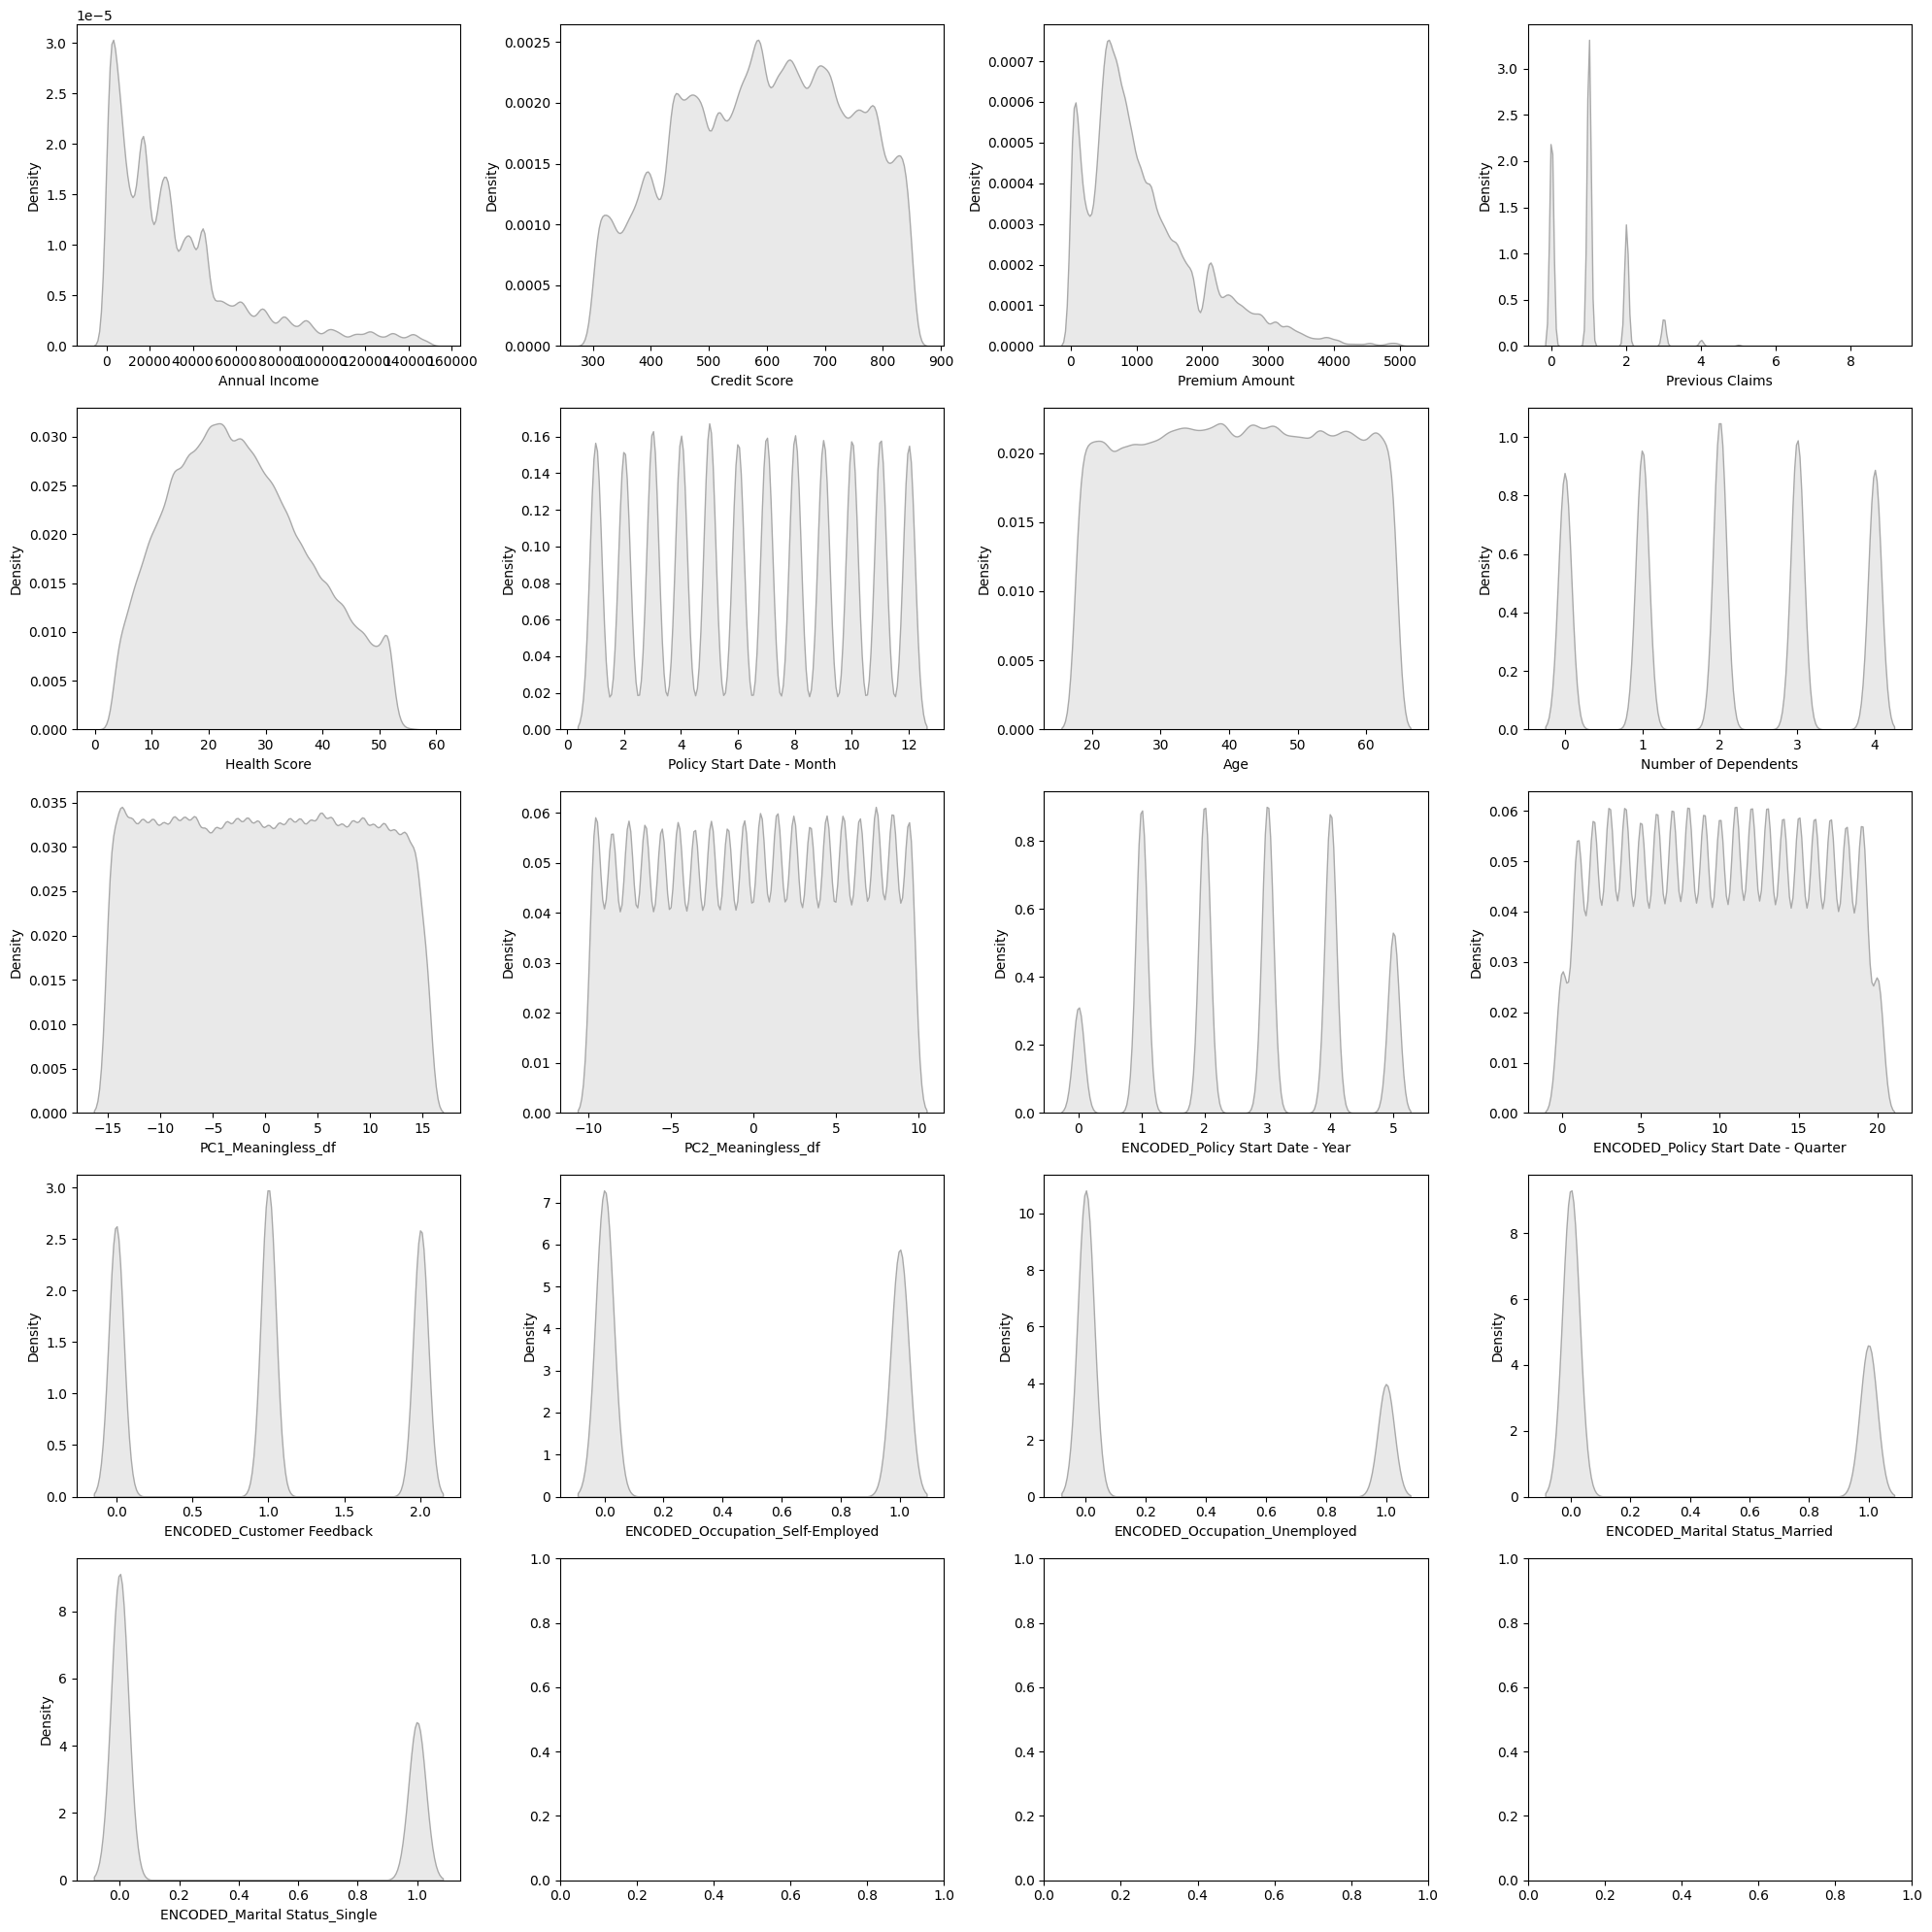

In [270]:
fig, axs = plt.subplots(3, 6, figsize=(20, 9))

for i, ax in zip(x_train.columns, axs.flatten()):
    sns.kdeplot(x_train[i], ax=ax, color="darkgray", fill=True)

plt.tight_layout()
plt.show()

In [358]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

In [359]:
def do_scaling(scaler):
    var_cols = list(map(lambda x : x.replace(" ", "_"), x_train.columns))
    scalers = {}
    cols = x_train.columns
    
    for i in range(len(cols)):
        scalers[f"SCALER_{var_cols[i]}"] = scaler
        
        x_train[f"SCALER_{var_cols[i]}"] = scalers[f"SCALER_{var_cols[i]}"].fit_transform(x_train[[cols[i]]]).flatten()
        x_train.drop(columns=cols[i], inplace=True)

        x_validate[f"SCALER_{var_cols[i]}"] = scalers[f"SCALER_{var_cols[i]}"].transform(x_validate[[cols[i]]]).flatten()
        x_validate.drop(columns=cols[i], inplace=True)

        test[f"SCALER_{var_cols[i]}"] = scalers[f"SCALER_{var_cols[i]}"].transform(test[[cols[i]]]).flatten()
        test.drop(columns=cols[i], inplace=True)
    
    return scalers

In [360]:
scaler_objects = do_scaling(RobustScaler())
scaler_objects

{'SCALER_Annual_Income': RobustScaler(),
 'SCALER_Credit_Score': RobustScaler(),
 'SCALER_Previous_Claims': RobustScaler(),
 'SCALER_Health_Score': RobustScaler(),
 'SCALER_Policy_Start_Date_-_Month': RobustScaler(),
 'SCALER_Age': RobustScaler(),
 'SCALER_Number_of_Dependents': RobustScaler(),
 'SCALER_PC1_Meaningless_df': RobustScaler(),
 'SCALER_PC2_Meaningless_df': RobustScaler(),
 'SCALER_ENCODED_Policy_Start_Date_-_Year': RobustScaler(),
 'SCALER_ENCODED_Policy_Start_Date_-_Quarter': RobustScaler(),
 'SCALER_ENCODED_Customer_Feedback': RobustScaler(),
 'SCALER_ENCODED_Occupation_Self-Employed': RobustScaler(),
 'SCALER_ENCODED_Occupation_Unemployed': RobustScaler(),
 'SCALER_ENCODED_Marital_Status_Married': RobustScaler(),
 'SCALER_ENCODED_Marital_Status_Single': RobustScaler()}

In [361]:
x_train.head(3)

,SCALER_Annual_Income,SCALER_Credit_Score,SCALER_Previous_Claims,SCALER_Health_Score,SCALER_Policy_Start_Date_-_Month,SCALER_Age,SCALER_Number_of_Dependents,SCALER_PC1_Meaningless_df,SCALER_PC2_Meaningless_df,SCALER_ENCODED_Policy_Start_Date_-_Year,SCALER_ENCODED_Policy_Start_Date_-_Quarter,SCALER_ENCODED_Customer_Feedback,SCALER_ENCODED_Occupation_Self-Employed,SCALER_ENCODED_Occupation_Unemployed,SCALER_ENCODED_Marital_Status_Married,SCALER_ENCODED_Marital_Status_Single
1197256,2.949326,-0.012931,-1.0,-0.172109,0.0,-0.173913,1.0,-0.998905,0.702654,0.666667,0.9,0.0,0.0,1.0,1.0,0.0
776249,0.139327,0.422414,0.0,1.578427,-0.6,-0.478261,-1.0,0.000314,-0.098834,0.666667,0.8,0.5,0.0,0.0,0.0,0.0
17950,0.990772,-0.267241,1.0,1.480338,-0.8,0.434783,-0.5,0.533489,0.000888,0.000000,0.0,-0.5,0.0,0.0,0.0,0.0


In [362]:
x_validate.head(3)

,SCALER_Annual_Income,SCALER_Credit_Score,SCALER_Previous_Claims,SCALER_Health_Score,SCALER_Policy_Start_Date_-_Month,SCALER_Age,SCALER_Number_of_Dependents,SCALER_PC1_Meaningless_df,SCALER_PC2_Meaningless_df,SCALER_ENCODED_Policy_Start_Date_-_Year,SCALER_ENCODED_Policy_Start_Date_-_Quarter,SCALER_ENCODED_Customer_Feedback,SCALER_ENCODED_Occupation_Self-Employed,SCALER_ENCODED_Occupation_Unemployed,SCALER_ENCODED_Marital_Status_Married,SCALER_ENCODED_Marital_Status_Single
798481,0.049719,0.056034,0.0,-0.947641,0.0,1.000000,-0.5,-0.666319,-0.297438,0.333333,0.5,0.0,1.0,0.0,0.0,0.0
115232,1.915716,-0.030172,-1.0,0.529618,-0.6,0.782609,1.0,-0.665569,0.801850,0.666667,0.8,0.5,0.0,0.0,0.0,1.0
110208,0.018102,0.081897,-1.0,1.012260,0.0,-0.130435,-0.5,0.000123,-0.599540,0.666667,0.9,0.5,0.0,0.0,0.0,1.0


In [363]:
test.head(3)

,SCALER_Annual_Income,SCALER_Credit_Score,SCALER_Previous_Claims,SCALER_Health_Score,SCALER_Policy_Start_Date_-_Month,SCALER_Age,SCALER_Number_of_Dependents,SCALER_PC1_Meaningless_df,SCALER_PC2_Meaningless_df,SCALER_ENCODED_Policy_Start_Date_-_Year,SCALER_ENCODED_Policy_Start_Date_-_Quarter,SCALER_ENCODED_Customer_Feedback,SCALER_ENCODED_Occupation_Self-Employed,SCALER_ENCODED_Occupation_Unemployed,SCALER_ENCODED_Marital_Status_Married,SCALER_ENCODED_Marital_Status_Single
1200000,-0.600366,-0.452586,1.0,-0.963373,0.0,-0.565217,1.0,-0.798720,0.901409,0.333333,0.5,-0.5,1.0,0.0,0.0,1.0
1200001,2.777590,-0.974138,0.0,-0.639462,-0.4,-0.434783,0.0,0.400466,0.400853,0.666667,0.9,0.5,1.0,0.0,1.0,0.0
1200002,-0.196773,0.952586,0.0,-0.018445,-0.4,0.260870,-1.0,-0.732419,0.602589,0.333333,0.5,0.0,0.0,1.0,0.0,0.0


#
---
#

# Joining All Data

In [373]:
train = pd.concat([pd.concat([x_train, y_train], axis=1), pd.concat([x_validate, y_validate], axis=1)]).sort_index()
train.head(3)

,SCALER_Annual_Income,SCALER_Credit_Score,SCALER_Previous_Claims,SCALER_Health_Score,SCALER_Policy_Start_Date_-_Month,SCALER_Age,SCALER_Number_of_Dependents,SCALER_PC1_Meaningless_df,SCALER_PC2_Meaningless_df,SCALER_ENCODED_Policy_Start_Date_-_Year,SCALER_ENCODED_Policy_Start_Date_-_Quarter,SCALER_ENCODED_Customer_Feedback,SCALER_ENCODED_Occupation_Self-Employed,SCALER_ENCODED_Occupation_Unemployed,SCALER_ENCODED_Marital_Status_Married,SCALER_ENCODED_Marital_Status_Single,Premium Amount
0,-0.389068,-0.974138,1.0,-0.117811,1.2,-0.956522,-0.5,0.467370,0.700273,0.333333,0.7,-0.5,1.0,0.0,1.0,0.0,2869.0
1,0.201469,0.413793,0.0,-0.515614,0.0,-0.086957,0.5,-0.266006,0.200902,0.333333,0.5,0.0,1.0,0.0,0.0,0.0,1483.0
2,0.035576,-0.185345,0.0,1.273207,0.6,-0.782609,0.5,0.933745,0.399349,0.333333,0.6,0.5,1.0,0.0,0.0,0.0,567.0


In [374]:
test.head(3)

,SCALER_Annual_Income,SCALER_Credit_Score,SCALER_Previous_Claims,SCALER_Health_Score,SCALER_Policy_Start_Date_-_Month,SCALER_Age,SCALER_Number_of_Dependents,SCALER_PC1_Meaningless_df,SCALER_PC2_Meaningless_df,SCALER_ENCODED_Policy_Start_Date_-_Year,SCALER_ENCODED_Policy_Start_Date_-_Quarter,SCALER_ENCODED_Customer_Feedback,SCALER_ENCODED_Occupation_Self-Employed,SCALER_ENCODED_Occupation_Unemployed,SCALER_ENCODED_Marital_Status_Married,SCALER_ENCODED_Marital_Status_Single
1200000,-0.600366,-0.452586,1.0,-0.963373,0.0,-0.565217,1.0,-0.798720,0.901409,0.333333,0.5,-0.5,1.0,0.0,0.0,1.0
1200001,2.777590,-0.974138,0.0,-0.639462,-0.4,-0.434783,0.0,0.400466,0.400853,0.666667,0.9,0.5,1.0,0.0,1.0,0.0
1200002,-0.196773,0.952586,0.0,-0.018445,-0.4,0.260870,-1.0,-0.732419,0.602589,0.333333,0.5,0.0,0.0,1.0,0.0,0.0


In [376]:
df = pd.concat([train, test])

#
---
#

# Download the `Model Ready df`

In [377]:
df.to_csv("trainable_df.csv", index=False)